# CDS ML Assignment 3
##### Group 37 - Rahul Deivasigamani (S1157698) - Joshua John Gigi (S1140063) - Anestis Pantazis (S1169388)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.special import factorial, comb
from scipy.optimize import minimize_scalar
from scipy.stats import gamma, norm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import time

## Ex 4.1

Linear regression is one of the few examples where the minimization of the loss function can be worked out exactly. In this exercise you will check that gradient descent converges to the right minimizer.

Generate $P=100$ random vectors $x^\mu$ in $N=10$ dimension, with $x_i^\mu$ i.i.d. normally distributed, and their corresponding Gaussian distributed outputs $t^\mu$.

The objective is to learn a linear model
$$y(x, w)=\sum_{j=1}^N w_j x_j$$

The best parameters $w$ are found by minimizing:
$$E(w) =\frac{1}{2P}\sum_{\mu=1}^P \left[t^\mu - y(x^\mu, w)\right]^2$$

which, as we saw in an earlier lecture, can be considered as a likelihood maximization under a Gaussian model. Proceed as follows:

1. compute the gradient and the Hessian of the loss function $E$;
2. find the solution analytically;
3. highlight the relation between the uniqueness of solutions and the Hessian - discuss possible ways to solve the problem in the case where the solution is not unique;
4. implement gradient descent and show that it converges to the solutions found in point 2.

### Solution 4.1

#### 1.

$E(w) =\frac{1}{2P}\sum_{\mu=1}^P \left[t^\mu - y(x^\mu, w)\right]^2$

$\frac{\partial E}{\partial w_k} = \frac{\partial}{\partial w_k}\frac{1}{2P}\sum_{\mu=1}^P \left(t^\mu - \sum_{j=1}^N w_jx_j^\mu\right)^2$

For each sample,

$e^\mu = t ^ \mu − \sum_{j=1}^N ​w_j​x_j^μ​$

Then,

$\frac{\partial E}{\partial w_k} = \frac{1}{2P}\sum_{\mu=1}^P\frac{\partial}{\partial w_k} (e^\mu)^2 = \frac{1}{2P}\sum_{\mu=1}^P 2(e^\mu) \frac{\partial e^\mu}{\partial w_k}$

$ \frac{\partial e^\mu}{\partial w_k} = \frac{\partial}{\partial w_k} \left( t^\mu - \sum_{j=1}^N w_jx_j^\mu \right) = -x_k^\mu$

Therefore,

$ \frac{\partial e^\mu}{\partial w_k} = \frac{1}{2P}\sum_{\mu=1}^P 2(e^\mu) -x_k^\mu$

$$ \nabla_w E(w) = - \frac{1}{P} X^T (t-Xw)$$

For Hessian,

$H_{kl} = \frac{\partial^2 E}{\partial w_k \partial w_l} = \frac{\partial}{\partial w_l} \frac{\partial E}{\partial w_k}$

$\frac{\partial}{\partial w_l} \left( t^\mu - \sum_{j=1}^N w_jx_j^\mu \right) = -x_l^\mu$

$H_{kl} = - \frac{1}{P} \sum_{\mu=1}^P  (-x_l^\mu)(x_k^\mu) $

$H_{kl} = \frac{1}{P} \sum_{\mu=1}^P x_l^\mu x_k^\mu $

$$H = \frac{1}{P} X^TX $$

#### 2.

$ \nabla_w E(w) = 0$

$E_\lambda(w) = \frac{1}{2P} || t-Xw || ^2 + \frac{\lambda}{2} || w || ^2 = 0$

$ \nabla_w E(w) = - \frac{1}{P} X^T (t-Xw) + \lambda w = 0 $

$ \frac{1}{P} X^TXw + \lambda w = \frac{1}{P} X^Tt $

$ w^* = (X^TX + \lambda PI)^{-1}X^Tt $

$ H_\lambda = \frac{1}{P}X^TX + \lambda I$

#### 3.

The Hessian gives information regarding the curvature of the error function in the weight-space. The rank of the Hessian determines whether the quadratic form is strictly convex, flat in some points or chaotic.

if $rank(X) = N$:

$X^TX$ is invertible with the Hessian having non-zero eigenvalues. $E(w)$ is strictly convex i.e. unique global minimizer. This decomposes into the normal equation:

$w^* = (X^TX)^{-1} X^Tt$

if $rank(X) < N$:

$X^TX$ is singular with zero eigenvalues i.e. flat in some directions. $E(w)$ is not strictly convex with non-unique minimizers. i.e.

Approach 1 - using Pseudo Inverses

$w^* = X^+t + (I-X^+X)z, z \in \mathbb{R}^N, X^+ \rarr pseudo-inverse$ 

Approach 2 - Regularisation

Ridge Regression using $l_2$ penalty.

$E_\lambda(w) = \frac{1}{2P} || t-Xw || ^2 + \frac{\lambda}{2} || w || ^2$

The Hessian becomes:

$H_\lambda = \frac{1}{P} X^TX + \lambda I$

$w^*_\lambda = (X^TX ++ \lambda PI)^{-1} X^Tt$

#### 4.

In [2]:
P = 100
N = 10

np.random.seed(0)

X = np.random.randn(P, N)
w_true = np.random.randn(N)
sigma = 0.1
noise = sigma * np.random.randn(P)
t = X @ w_true + noise

def gradient(w):
    return -(1.0 / P) * X.T @ (t - X @ w)
def loss(w):
    return 0.5 / P * np.sum((t - X @ w)**2)

eta = 1e-3
w_gd = np.zeros(N)
for it in range(5000):
    w_gd = w_gd - eta * gradient(w_gd)
    

w_analytic = np.linalg.pinv(X) @ t
H = (1.0 / P) * X.T @ X
eigvals = np.linalg.eigvalsh(H)
L = eigvals.max()

print(np.linalg.norm(w_gd-w_analytic))

0.023387306521234854


## Ex 4.2

Fill in the missing steps in the **Example** of section **Line Search**:
* provide an analytical expression for `lopt`,  `w1` and `d1`;
* check your results using a scalar minimization routine like the [Golden-section](https://en.wikipedia.org/wiki/Golden-section_search) method along the lines of [`scipy.optimize.golden`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.golden.html). You might want to implement it yourself for later use in **Ex 4.3.4**;
* check the correctness of the points in the plot.

### Solution 4.2

$E(w) = \frac{\lambda_1 w_1^2 + \lambda_2 w_2^2}{2}$

$w_0=(5, 5)$

$\nabla E(w) = \begin{pmatrix}\lambda_1 w_1\\ \lambda_2 w_2 \end{pmatrix}$ $H=\begin{pmatrix}\lambda_1 & 0\\[4pt]0 & \lambda_2\end{pmatrix}$

Taking the steepest descent,

$\nabla E(w_0) = \begin{pmatrix}5\lambda_1\\ 5\lambda_2 \end{pmatrix}= g_0$

$d_0=-g_0= -\begin{pmatrix}5\lambda_1\\ 5\lambda_2 \end{pmatrix}$

$l_{opt} = -\frac{\nabla E(w_0)^Tp}{p^THp}$

Since $p=d_0=-g_0$,

$l_{opt} = -\frac{g_0^Tg_0}{g_0^THg_0}$

$g_0^Tg_0 = 25(\lambda_1^2 + \lambda_2^2)$

$g_0^THg_0 = 25(\lambda_1^3 + \lambda_2^3)$

$$l_{opt} = \frac{\lambda_1^2 + \lambda_2^2}{\lambda_1^3 + \lambda_2^3}$$

$$w_1 = w_0+l_{opt}d_0 = w_0 - l_{opt}g_0$$

$w_{1,j} = 5(1-l_{opt}\lambda_j), j = 1,2$

$$d_1 = - \nabla E(w_1) = -Hw_1 = - \begin{pmatrix}\lambda_1w_{1,1}\\\lambda_2w_{1,2} \end{pmatrix}$$

analytic lopt: 0.26153846153846155
w1 (analytic): [ 3.69230769 -0.23076923]
d1 (analytic): [-3.69230769  0.92307692]
numeric lopt (golden): 0.2615384620187429
difference: 4.802813702298181e-10


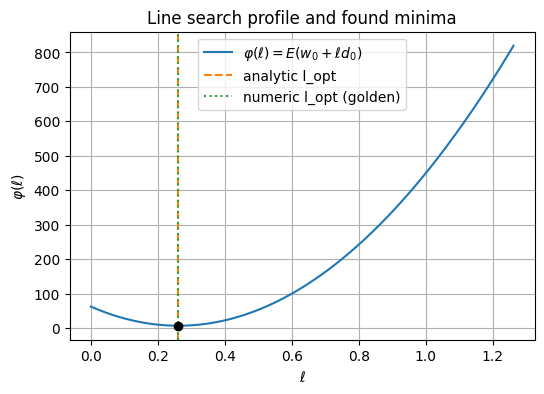

g1^T d0 (should be 0): 3.552713678800501e-15


In [3]:
lam1 = 1.0
lam2 = 4.0

w0 = np.array([5.0, 5.0])

def E(w):
    return 0.5 * (lam1 * w[0]**2 + lam2 * w[1]**2)

def gradE(w):
    return np.array([lam1 * w[0], lam2 * w[1]])

H = np.diag([lam1, lam2])

g0 = gradE(w0)
d0 = -g0

lopt_analytic = (g0 @ g0) / (g0 @ (H @ g0))
print("analytic lopt:", lopt_analytic)

w1_analytic = w0 + lopt_analytic * d0
d1_analytic = -gradE(w1_analytic)
print("w1 (analytic):", w1_analytic)
print("d1 (analytic):", d1_analytic)

phi = lambda l: E(w0 + l * d0)

def golden_section_minimize(f, a, b, tol=1e-8, maxiter=200):
    gr = (np.sqrt(5) - 1) / 2  # 0.618...
    c = b - gr * (b - a)
    d = a + gr * (b - a)
    fc = f(c); fd = f(d)
    it = 0
    while (b - a) > tol and it < maxiter:
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - gr * (b - a)
            fc = f(c)
        else:
            a, c, fc = c, d, fd
            d = a + gr * (b - a)
            fd = f(d)
        it += 1
    return (a + b) / 2

a, b = 0.0, 10.0
lopt_numeric = golden_section_minimize(phi, a, b, tol=1e-10)
print("numeric lopt (golden):", lopt_numeric)
print("difference:", abs(lopt_numeric - lopt_analytic))

ls = np.linspace(max(0, lopt_analytic - 1.0), lopt_analytic + 1.0, 400)
phis = [phi(l) for l in ls]

plt.figure(figsize=(6,4))
plt.plot(ls, phis, label=r'$\varphi(\ell)=E(w_0+\ell d_0)$')
plt.axvline(lopt_analytic, color='C1', linestyle='--', label='analytic l_opt')
plt.axvline(lopt_numeric, color='C2', linestyle=':', label='numeric l_opt (golden)')
plt.scatter([lopt_analytic], [phi(lopt_analytic)], color='black', zorder=5)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\varphi(\ell)$')
plt.legend()
plt.title('Line search profile and found minima')
plt.grid(True)
plt.show()

g1 = gradE(w1_analytic)
print("g1^T d0 (should be 0):", float(g1 @ d0))


## Ex 4.3

In this exercise you will implement a number of optimization algorithm to classify digits in the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset using logistic regression, with the loss function:

$$E(w)=-\frac{1}{P}\sum_{\mu=1}^P\left[t^\mu \log y(x^\mu,w)+(1-t^\mu)\log (1-y(x^\mu,w))\right]$$

The MNIST dataset contains 70000 images of digits from 0 to 9.

Proceed as follows:
* Download the dataset as explained below.
* Select the images of digits **3** and **7** for a two-class classification problem. You will find a total of 14434 images.
* Split the previously obtained set in two parts: 80% for the training set and 20% for testing.
* The raw data consists of pixel intensities from 0 to 255. Standardize the dataset so that the global pixel average is zero and the std is 1.
* Derive the gradient and Hessian for Logistic regression and implement the algorithms below. In the derivation, you will find the following property of the sigmoid function useful (_prove it!_):

$$\frac{d\sigma(x)}{dx}=\sigma(x) (1-\sigma(x))$$

which is nothing but the celebrated logistic differential equation, popular in the modeling of [population growth](https://en.wikipedia.org/wiki/Population_model).

For each algorithm, produce the requested output and share all the code. Make sure the code is reproducible so we can easily run it and check the results.

If optimization is too slow, feel free to report your results with a smaller dataset, by keeping only a subset of the original images.

There are a number of ways you can get the MNIST dataset. One option is to use scikit-learn:

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

X, y = mnist["data"].astype(float), mnist["target"].astype(float) # Note: images in X are flattened 28 x 28 = 784

Another option is to get started with [pytorch](https://pytorch.org/), which we will use to train deep networks. You may want to go through this introductory [tutorial](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

You can use [`torch.utils.data.DataLoader`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to extract the entire dataset from [`torchvision.datasets.MNIST`](https://docs.pytorch.org/vision/0.8/datasets.html#mnist).

### 4.3.1

* Implement gradient descent to minimize the loss function $E$ for logistic regression.
* Produce plots showing how $E$ decreases with iterations on both the training and test sets. Note that the training error should always decrease, but the test error may not.
* Test the effect of different values for the learning rate $\eta$.
* Experiment with **early stopping**. Divide your training set into an 80% training set and a 20% validation set (you are not allowed to use the test set to decide when to stop). Train on this reduced training set and monitor the error on both the training and validation sets. Stop the training if/when the validation error increases. Report the error on the test set.

### 4.3.2

* Add momentum with strength $\alpha$ to your gradient rule.
* Produce plots of how $E$ decreases with iterations on both the training and test sets.
* Test the effect of different values for $\alpha$ and $\eta$.

### 4.3.3

Add a **weight decay** term to $E$ (you may notice that momentum induces a slight overfitting):
$$E\left(w\right)=-\frac{1}{P}\sum_{\mu=1}^{P}\left[t^{\mu}\log y^{\mu}+\left(1-t^{\mu}\right)\log\left(1-y^{\mu}\right)\right]+\frac{\lambda}{2N}\sum_{i=0}^{N}w_{i}^{2}$$

Using $\lambda=0.1$ and the momentum method, report the final loss (without the regularization term) on both training and test sets after convergence, along with the number of iterations.

### 4.3.3

We'll now use this problem (with $\lambda=0.1$) and the results from gradient descent with momentum to compare with other methods.

### Newton method

Implement the Newton method for the logistic regression problem with weight decay. Produce plots showing how $E$ decreases with iterations on both the training and test sets. Discuss the compromise between number of iteration and computational burden.

### Line search

Implement the gradient method with a **line search**: in each iteration, compute the gradient at the current $w$: $d=-\nabla E(w)$, then numerically find the value of $\gamma > 0$ that minimizes $E(w+\gamma d)$. The main challenge is defining the initial interval for the search. Produce plots of how $E$ decreases with iterations on the training and test sets.

### Stochastic gradient descent

Implement the SGD method using a constant learning rate $\eta$ and mini-batch sizes. Produce plots showing how $E$ decreases with iterations on both the training and test sets for different values of $\eta$ and the size of each batch.

### Solution 4.3

In [5]:
import numpy as np
import matplotlib.pyplot as plt


# Set a seed for reproducibility
np.random.seed(777)

# Helper functions

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y_true, X, w, epsilon=1e-9):
    y_pred = sigmoid(X @ w)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon) # Avoid log(0)
    P = len(y_true)
    loss = -1/P * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

def plot_loss_history(history, title, xlabel="Iterations"):
    plt.figure()
    plt.plot(history['train_loss'], label=f"Train Loss: {history['train_loss'][-1]:.4f}")
    plt.plot(history['test_loss'], label=f"Test Loss: {history['test_loss'][-1]:.4f}")
    plt.xlabel(xlabel)
    plt.ylabel("Loss (E)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

#### Preparing the dataset

In [6]:
print("Preparing Data...")

# Download MNIST dataset
mnist = fetch_openml('mnist_784', as_frame=False)
X, y_str = mnist["data"].astype(float), mnist["target"].astype(float)

# Select images of digits 3 and 7
mask = (y_str == 3) | (y_str == 7)
X_filtered = X[mask]
y_filtered = y_str[mask]

# Convert labels to 0 (digit 3) and 1 (digit 7)
y = (y_filtered == 7).astype(int)
print(f"Filtered dataset size: {len(y)} images.")

# Split into 80% training and 20% testing
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the dataset
mean = X_train_full.mean()
std = X_train_full.std()
X_train_full_std = (X_train_full - mean) / std
X_test_std = (X_test - mean) / std

# Add bias term (x_0 = 1)
X_train_full_b = np.c_[np.ones((X_train_full_std.shape[0], 1)), X_train_full_std]
X_test_b = np.c_[np.ones((X_test_std.shape[0], 1)), X_test_std]

print("Data preparation complete.")

Preparing Data...
Filtered dataset size: 14434 images.
Data preparation complete.


The loss function to minimize:

$$E(w)=-\frac{1}{P}\sum_{\mu=1}^P\left[t^\mu \log y(x^\mu,w)+(1-t^\mu)\log (1-y(x^\mu,w))\right]$$



#### Sigmoid Derivative Property (Proof)

The sigmoid function is defined as $$\sigma(a) = \frac{1}{1 + e^{-a}}$$ To find its derivative with respect to $a$, we use the chain rule:
$$\frac{d\sigma(a)}{da} = \frac{d}{da}(1 + e^{-a})^{-1} = -1 \cdot (1 + e^{-a})^{-2} \cdot (-e^{-a}) = \frac{e^{-a}}{(1 + e^{-a})^2}$$
We can rewrite this as:
$$\frac{e^{-a}}{(1 + e^{-a})^2} = \frac{1}{1 + e^{-a}} \cdot \frac{e^{-a}}{1 + e^{-a}} = \frac{1}{1 + e^{-a}} \cdot \frac{(1 + e^{-a}) - 1}{1 + e^{-a}} = \sigma(a) \cdot \left(1 - \frac{1}{1 + e^{-a}}\right) = \sigma(a)(1 - \sigma(a))$$

$$\therefore \frac{d\sigma(a)}{da} = \sigma(a)(1 - \sigma(a))$$

#### Gradient of the Loss Function

The loss function is $$E(w)=-\frac{1}{P}\sum_{\mu=1}^P E^\mu$$
where $E^\mu = \left[t^\mu \log y^\mu+(1-t^\mu)\log (1-y^\mu)\right]$

The term $y^\mu$ is the sigmoid function applied to the linear activation $a^\mu = w^T x^\mu$, so $y^\mu = \sigma(a^\mu)$.

Using chain rule to find the gradient with respect to a single weight $w_i$ for a single sample $\mu$:
$$\frac{\partial E^\mu}{\partial w_i} = \frac{\partial E^\mu}{\partial y^\mu} \frac{\partial y^\mu}{\partial a^\mu} \frac{\partial a^\mu}{\partial w_i} = \left( \frac{y^\mu - t^\mu}{y^\mu(1-y^\mu)} \right) \cdot \left( y^\mu(1-y^\mu) \right) \cdot \left( x_i^\mu \right) = (y^\mu - t^\mu)x_i^\mu$$
Averaging over all $P$ samples, the full gradient vector is:
$$\nabla E(w) = \frac{1}{P}\sum_{\mu=1}^P (y^\mu - t^\mu)x^\mu = \frac{1}{P} X^T(y-t)$$

For the **weight decay** term $\frac{\lambda}{2N}\sum_{i=0}^{N}w_{i}^{2}$, its gradient is simply $\frac{\lambda}{N}w$. 

$\therefore$ The total gradient is:
$$\nabla E_{reg}(w) = \frac{1}{P} X^T(y-t) + \frac{\lambda}{N}w$$

#### Hessian of the Loss Function

The Hessian matrix $H$ has elements $H_{ij} = \frac{\partial^2 E}{\partial w_i \partial w_j}$.
$$H_{ij} = \frac{\partial}{\partial w_j} \left( \frac{1}{P}\sum_{\mu=1}^P (y^\mu - t^\mu)x_i^\mu \right) = \frac{1}{P}\sum_{\mu=1}^P x_i^\mu \frac{\partial y^\mu}{\partial w_j} = \frac{1}{P}\sum_{\mu=1}^P x_i^\mu \left(y^\mu(1-y^\mu)x_j^\mu\right)$$
In matrix form, this can be written as $$H = \frac{1}{P}X^T R X$$ 
where $R$ is a diagonal matrix with $R_{\mu\mu} = y^\mu(1-y^\mu)$.

For the **weight decay** term, the Hessian is $\frac{\lambda}{N}I$, where $I$ is the identity matrix. 

$\therefore$ The total Hessian is:
$$H_{reg} = \frac{1}{P}X^T R X + \frac{\lambda}{N}I$$

#### 4.3.1 Gradient Descent

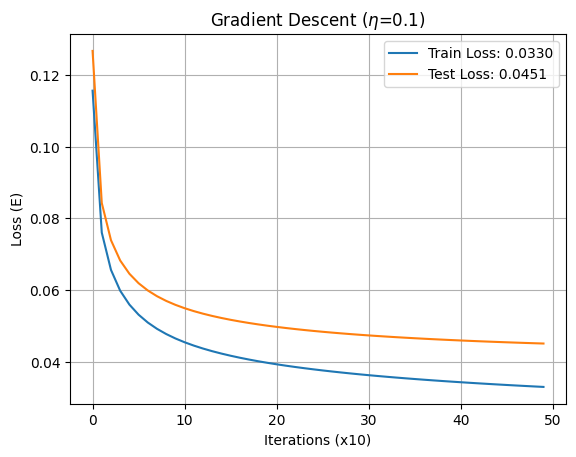

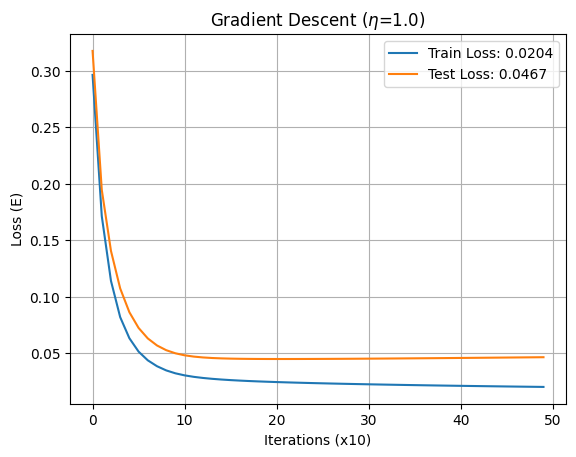

C:\Users\joshua\AppData\Local\Temp\ipykernel_5524\2391035239.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


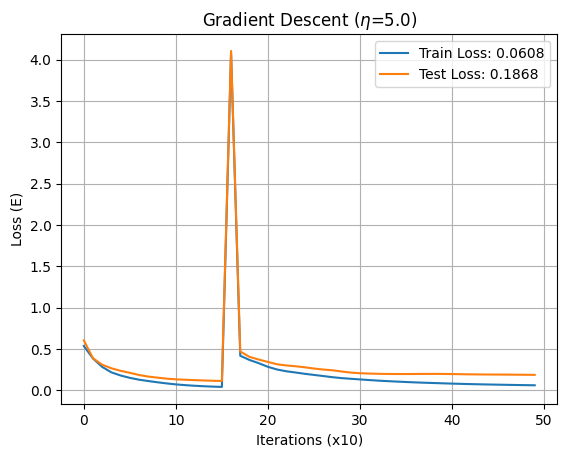

In [7]:
def gradient_descent(X_train, y_train, X_test, y_test, eta, n_iterations):
    P, N = X_train.shape
    w = np.random.randn(N) * 0.01
    history = {'train_loss': [], 'test_loss': []}

    for i in range(n_iterations):
        y_pred_train = sigmoid(X_train @ w)
        gradient = (1/P) * X_train.T @ (y_pred_train - y_train)
        w -= eta * gradient

        if i % 10 == 0:
            train_loss = compute_loss(y_train, X_train, w)
            test_loss = compute_loss(y_test, X_test, w)
            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)
    return w, history

etas = [0.1, 1.0, 5.0]
for eta in etas:
    w_gd, history_gd = gradient_descent(X_train_full_b, y_train_full, X_test_b, y_test, eta=eta, n_iterations=500)
    plot_loss_history(history_gd, f'Gradient Descent ($\eta$={eta})', xlabel="Iterations (x10)")

 Small $\eta$ (0.1) converges slowly, while a large $\eta$ (5.0) diverges as the algorithm overshoots the minimum.

##### Early Stopping

Early stopping at iteration 430. Best validation loss: 0.0465
Final error on the test set: 0.0497


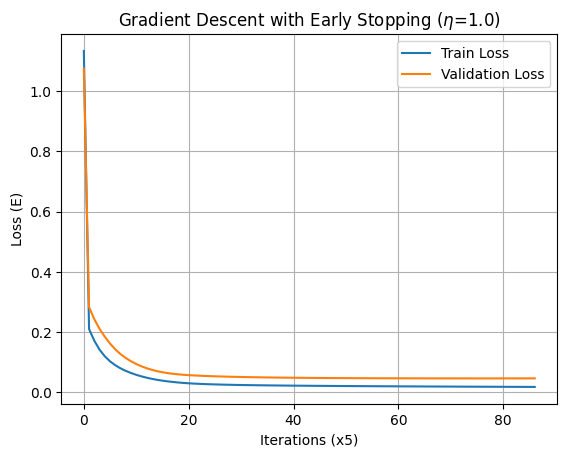

In [8]:
def gd_early_stopping(X_train_full, y_train_full, X_test, y_test, eta, n_iterations, patience=10):
    # Split training data into a smaller training set and a validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)
    
    P, N = X_train.shape
    w = np.random.randn(N) * 0.01
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_w = None
    patience_counter = 0

    for i in range(n_iterations):
        y_pred_train = sigmoid(X_train @ w)
        gradient = (1/P) * X_train.T @ (y_pred_train - y_train)
        w -= eta * gradient

        if i % 5 == 0:
            train_loss = compute_loss(y_train, X_train, w)
            val_loss = compute_loss(y_val, X_val, w)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_w = w.copy()
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping at iteration {i}. Best validation loss: {best_val_loss:.4f}")
                break
    
    test_loss_final = compute_loss(y_test, X_test, best_w)
    print(f"Final error on the test set: {test_loss_final:.4f}")
    return best_w, history

w_es, history_es = gd_early_stopping(X_train_full_b, y_train_full, X_test_b, y_test, eta=1.0, n_iterations=1000)

plt.figure()
plt.plot(history_es['train_loss'], label="Train Loss")
plt.plot(history_es['val_loss'], label="Validation Loss")
plt.xlabel("Iterations (x5)")
plt.ylabel("Loss (E)")
plt.title("Gradient Descent with Early Stopping ($\eta$=1.0)")
plt.legend()
plt.grid(True)
plt.show()

Early stopping is an effective regularization technique, preventing overfitting by monitoring a validation set.

#### 4.3.2 Gradient Descent with Momentum

C:\Users\joshua\AppData\Local\Temp\ipykernel_5524\2391035239.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


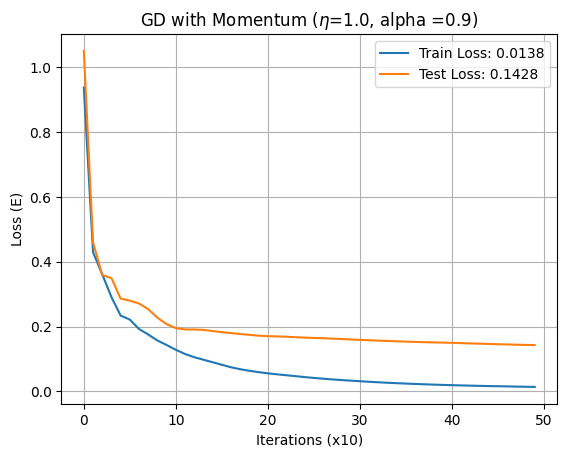

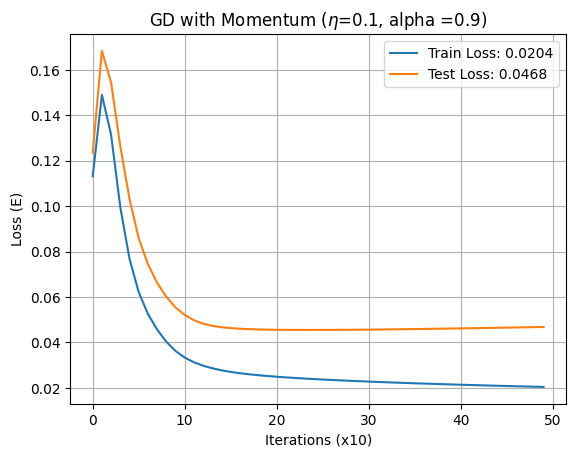

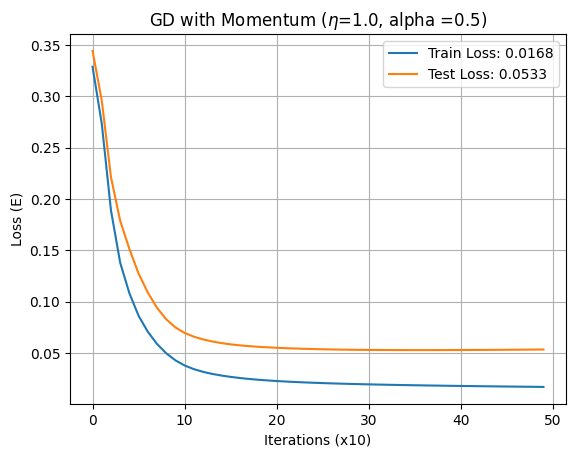

In [9]:
def gd_momentum(X_train, y_train, X_test, y_test, eta, alpha, n_iterations):
    P, N = X_train.shape
    w = np.random.randn(N) * 0.01
    velocity = np.zeros(N)
    history = {'train_loss': [], 'test_loss': []}

    for i in range(n_iterations):
        y_pred_train = sigmoid(X_train @ w)
        gradient = (1/P) * X_train.T @ (y_pred_train - y_train)
        velocity = alpha * velocity - eta * gradient
        w += velocity
        
        if i % 10 == 0:
            train_loss = compute_loss(y_train, X_train, w)
            test_loss = compute_loss(y_test, X_test, w)
            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)
    return w, history

params = [(1.0, 0.9), (0.1, 0.9), (1.0, 0.5)]
for eta, alpha in params:
    w_mom, history_mom = gd_momentum(X_train_full_b, y_train_full, X_test_b, y_test, eta=eta, alpha=alpha, n_iterations=500)
    plot_loss_history(history_mom, f'GD with Momentum ($\eta$={eta}, alpha ={alpha})', xlabel="Iterations (x10)")

Adding a momentum term ($\alpha$ > 0) accelerates convergence. It helps dampen oscillations and finds a better minimum faster than standard gradient descent.

#### 4.3.3 Weight Decay

Using $\lambda$=0.1 and Momentum:
Converged after 500 iterations.
Final Training Loss (unregularized): 0.0105
Final Test Loss (unregularized): 0.0780


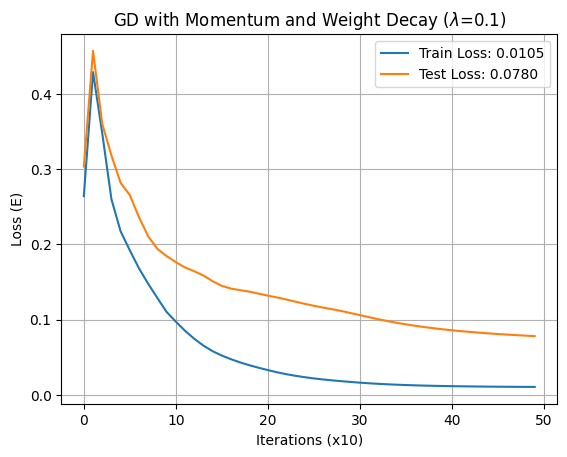

In [10]:
def gd_momentum_reg(X_train, y_train, X_test, y_test, eta, alpha, lambda_val, n_iterations):
    P, N = X_train.shape
    w = np.random.randn(N) * 0.01
    velocity = np.zeros(N)
    history = {'train_loss': [], 'test_loss': []}
    
    for i in range(n_iterations):
        y_pred_train = sigmoid(X_train @ w)
        grad_reg_term = (lambda_val / N) * w
        grad_reg_term[0] = 0 # No regularization on bias term
        gradient = (1/P) * X_train.T @ (y_pred_train - y_train) + grad_reg_term
        
        velocity = alpha * velocity - eta * gradient
        w += velocity
        
        if i % 10 == 0:
            # Report the unregularized loss for comparison
            train_loss = compute_loss(y_train, X_train, w)
            test_loss = compute_loss(y_test, X_test, w)
            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)
    return w, history, i + 1

lambda_val = 0.1
w_reg, history_reg, iters = gd_momentum_reg(
    X_train_full_b, y_train_full, X_test_b, y_test, eta=1.0, alpha=0.9, lambda_val=lambda_val, n_iterations=500)

print(f"Using $\lambda$={lambda_val} and Momentum:")
print(f"Converged after {iters} iterations.")
print(f"Final Training Loss (unregularized): {history_reg['train_loss'][-1]:.4f}")
print(f"Final Test Loss (unregularized): {history_reg['test_loss'][-1]:.4f}")
plot_loss_history(history_reg, f'GD with Momentum and Weight Decay ($\lambda$={lambda_val})', xlabel="Iterations (x10)")

With $\lambda=0.1$, we can see that the gap between the train loss and test loss is large. This indicates that there is still some overfitting due to small $\lambda$ value. 

#### 4.3.4 Other Methods

##### Newton's Method

Newton Iteration 1 | Time: 1.97s
Newton Iteration 2 | Time: 1.92s
Newton Iteration 3 | Time: 2.11s
Newton Iteration 4 | Time: 2.01s
Newton Iteration 5 | Time: 1.78s
Newton Iteration 6 | Time: 1.63s
Newton Iteration 7 | Time: 1.94s
Newton Iteration 8 | Time: 1.81s
Newton Iteration 9 | Time: 2.25s
Newton Iteration 10 | Time: 2.23s


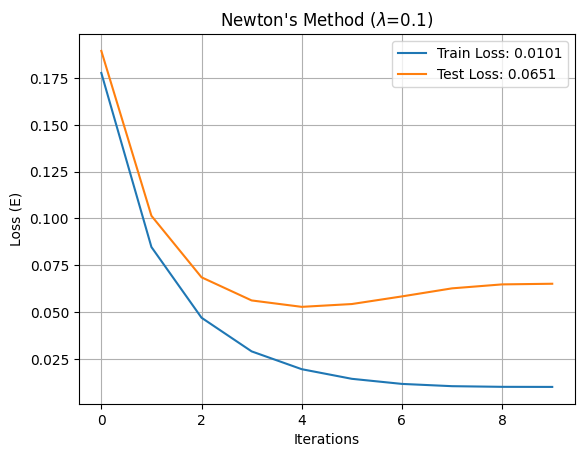

In [11]:
def newton_method(X_train, y_train, X_test, y_test, lambda_val, n_iterations):
    P, N = X_train.shape
    w = np.random.randn(N) * 0.01
    history = {'train_loss': [], 'test_loss': []}
    identity = np.identity(N)
    
    for i in range(n_iterations):
        start_time = time.time()
        y_pred_train = sigmoid(X_train @ w)
        
        # Gradient
        grad_reg_term = (lambda_val / N) * w; grad_reg_term[0] = 0
        gradient = (1/P) * X_train.T @ (y_pred_train - y_train) + grad_reg_term
        
        # Hessian
        R = np.diag(y_pred_train * (1 - y_pred_train))
        hessian = (1/P) * (X_train.T @ R @ X_train) + (lambda_val / N) * identity
        
        w -= np.linalg.inv(hessian) @ gradient
        
        train_loss = compute_loss(y_train, X_train, w)
        test_loss = compute_loss(y_test, X_test, w)
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        
        print(f"Newton Iteration {i+1} | Time: {time.time() - start_time:.2f}s")
    return w, history

w_newton, history_newton = newton_method(
    X_train_full_b, y_train_full, X_test_b, y_test, lambda_val=0.1, n_iterations=10)
plot_loss_history(history_newton, "Newton's Method ($\lambda$=0.1)")

This method converges in very few iterations because it uses the Hessian to find a more direct path to the minimum. However, the computational burden of calculating and inverting the Hessian at each step makes it impractical for high-dimensional problems like this one.

##### Line Search

C:\Users\joshua\AppData\Local\Temp\ipykernel_5524\2391035239.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


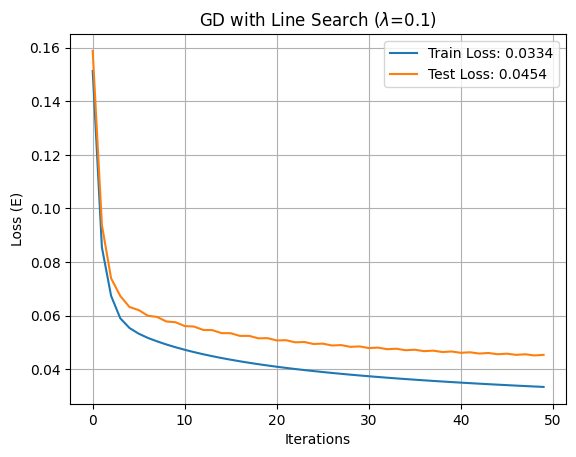

In [12]:
def compute_loss_reg(y_true, X, w, lambda_val):
    unreg_loss = compute_loss(y_true, X, w)
    l2_term = (lambda_val / (2 * len(w))) * np.sum(w[1:]**2)
    return unreg_loss + l2_term

def gd_line_search(X_train, y_train, X_test, y_test, lambda_val, n_iterations):
    P, N = X_train.shape
    w = np.random.randn(N) * 0.01
    history = {'train_loss': [], 'test_loss': []}
    
    for i in range(n_iterations):
        y_pred_train = sigmoid(X_train @ w)
        grad_reg_term = (lambda_val / N) * w; grad_reg_term[0] = 0
        gradient = (1/P) * X_train.T @ (y_pred_train - y_train) + grad_reg_term
        d = -gradient
        
        def objective(gamma):
            return compute_loss_reg(y_train, X_train, w + gamma * d, lambda_val)
        
        res = minimize_scalar(objective, bounds=(0, 10), method='bounded')
        gamma_opt = res.x
        w += gamma_opt * d
        
        train_loss = compute_loss(y_train, X_train, w)
        test_loss = compute_loss(y_test, X_test, w)
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
    return w, history

w_ls, history_ls = gd_line_search(
    X_train_full_b, y_train_full, X_test_b, y_test, lambda_val=0.1, n_iterations=50)
plot_loss_history(history_ls, "GD with Line Search ($\lambda$=0.1)")

This method automates the tuning of the learning rate at each step. It converges faster than fixed-rate GD but is slower per iteration due to the inner optimization loop.

##### Stochastic Gradient Descent (SGD)

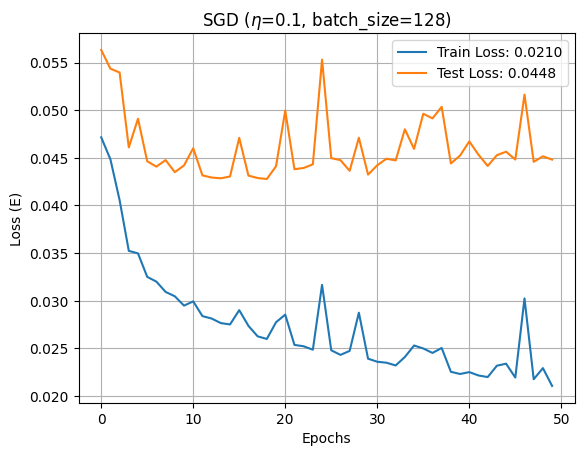

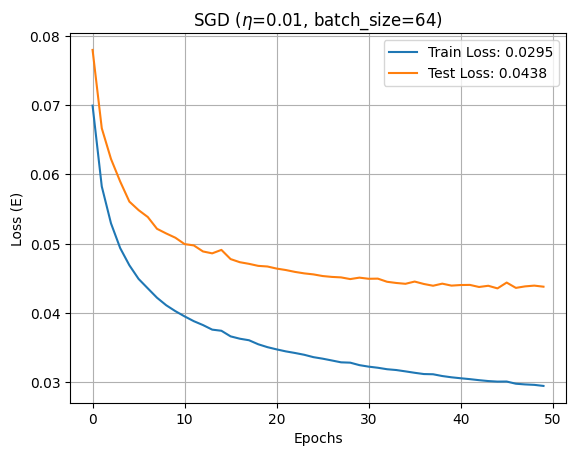

In [13]:
def sgd(X_train, y_train, X_test, y_test, eta, batch_size, n_epochs, lambda_val):
    P, N = X_train.shape
    w = np.random.randn(N) * 0.01
    history = {'train_loss': [], 'test_loss': []}
    
    for epoch in range(n_epochs):
        shuffled_indices = np.random.permutation(P)
        X_train_shuffled = X_train[shuffled_indices]
        y_train_shuffled = y_train[shuffled_indices]
        
        for i in range(0, P, batch_size):
            X_batch = X_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]
            
            y_pred_batch = sigmoid(X_batch @ w)
            grad_reg_term = (lambda_val / N) * w; grad_reg_term[0] = 0
            gradient = (1/len(y_batch)) * X_batch.T @ (y_pred_batch - y_batch) + grad_reg_term
            w -= eta * gradient
            
        # Record loss at the end of each epoch
        train_loss = compute_loss(y_train, X_train, w)
        test_loss = compute_loss(y_test, X_test, w)
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
    return w, history

sgd_params = [(0.1, 128), (0.01, 64)]
for eta, batch_size in sgd_params:
    w_sgd, history_sgd = sgd(
        X_train_full_b, y_train_full, X_test_b, y_test, 
        eta=eta, batch_size=batch_size, n_epochs=50, lambda_val=0.1)
    plot_loss_history(history_sgd, f'SGD ($\eta$={eta}, batch_size={batch_size})', xlabel="Epochs")

By using mini-batches, SGD makes rapid but noisy progress.

### Ex 4.4

Write your own version of a one-hidden layer neural network trained with MSE as in the section **Local minima** and train it on the same dataset using gradient descent. Experiment with both $\tanh$ and ReLu activation functions.

Report the training and test error over training and visualize the final regression performance for three values of `num_hidden`: 3, 10, 50.

#### Solution 4.4

Final Test MSE by (activation, H):
('tanh', 3): 0.0360
('tanh', 10): 0.0526
('tanh', 50): 0.0332
('relu', 3): 0.1912
('relu', 10): 0.1090
('relu', 50): 0.0286


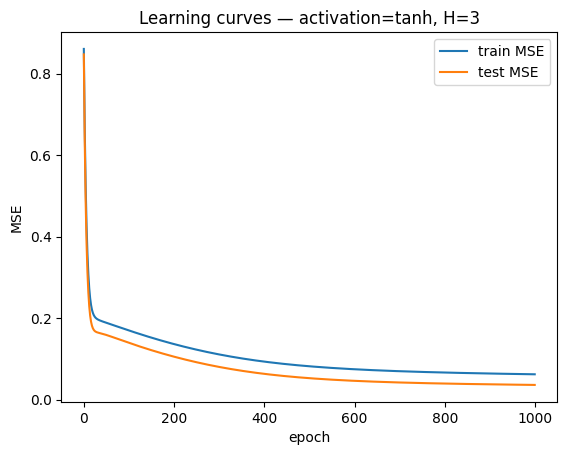

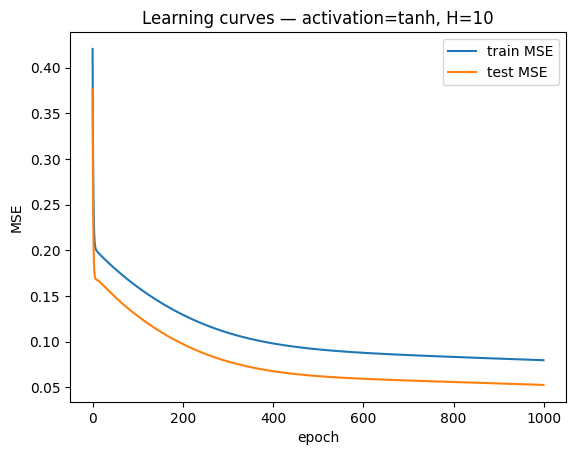

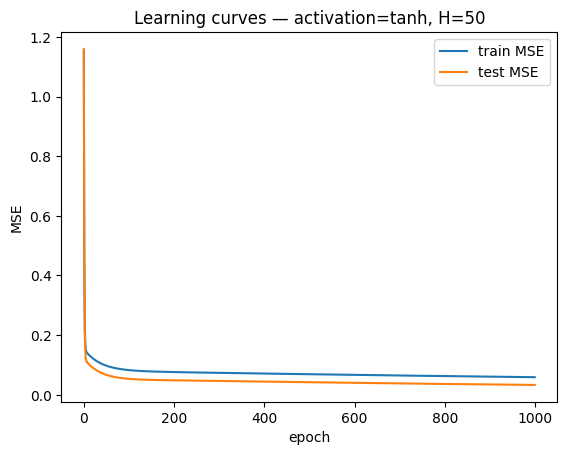

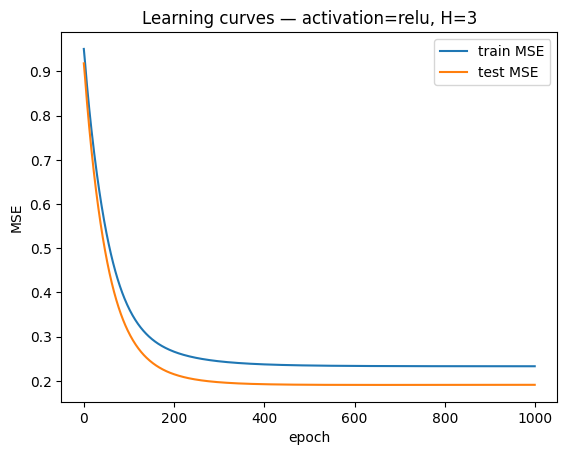

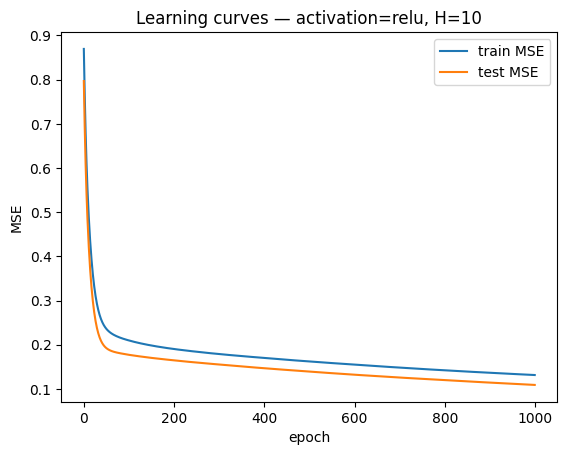

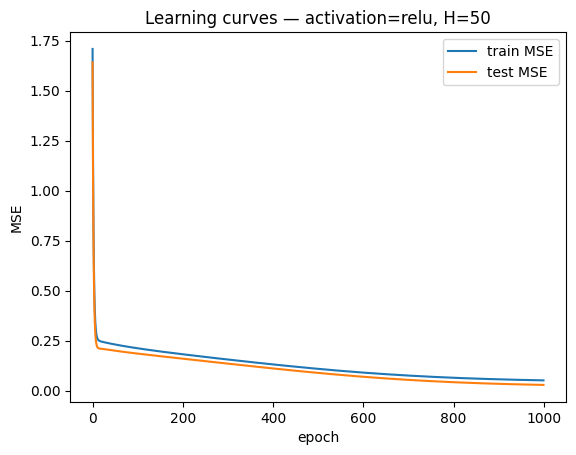

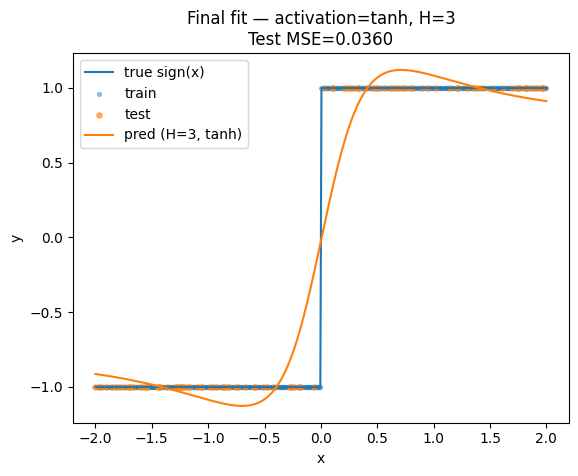

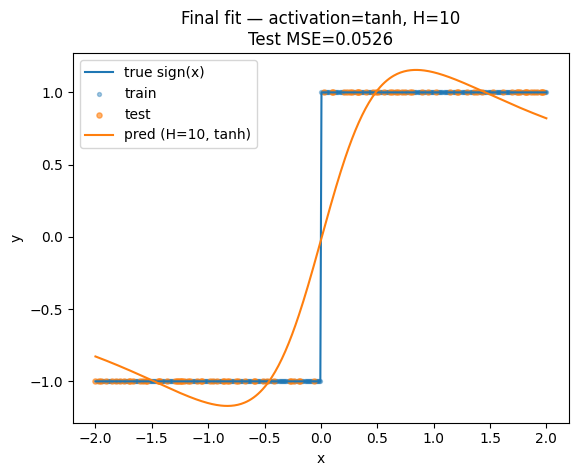

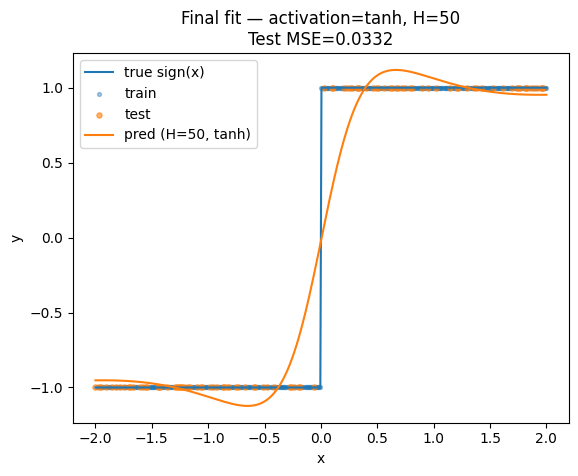

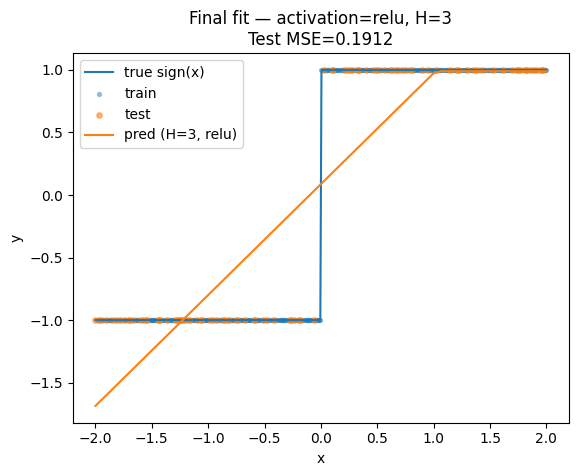

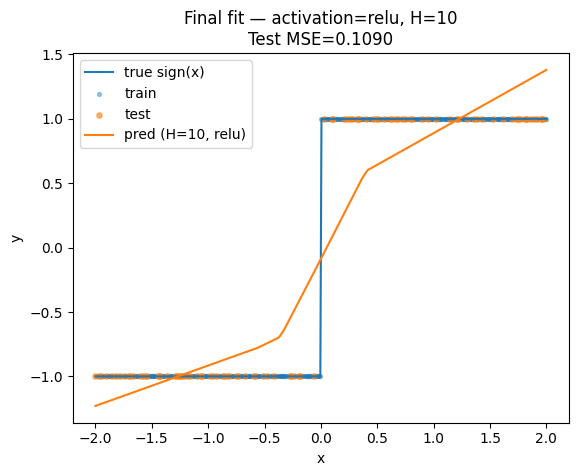

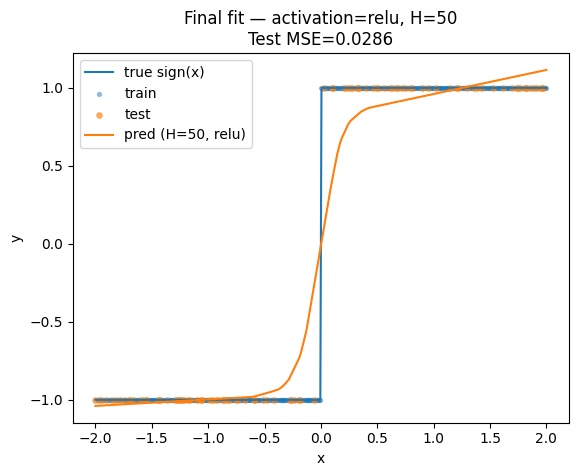

In [14]:
# -------------
# Dataset (Local minima)
# -------------
x = np.linspace(-2.0, 2.0, 400).reshape(-1, 1)
y = np.sign(x)  # piecewise-constant target
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# ---------------
# Activations
# ---------------
def relu(u): return np.maximum(0.0, u)
def drelu(u): return (u > 0).astype(u.dtype)
def tanh(u): return np.tanh(u)
def dtanh(u): t = np.tanh(u); return 1.0 - t*t

# ---------------
# One-hidden-layer NN + full-batch GD w/ MSE
# ---------------
def train_1hl_gd(
    Xtr, ytr, Xte, yte,
    H=10, activation="tanh", lr=0.05, epochs=1000, reg=1e-4, seed=7
):
    """
    Train a 1HL network: ŷ = act(XW + b) v + c
    Loss: mean squared error + L2(reg) on W, v.
    Full-batch GD updates.
    """
    rng = np.random.default_rng(seed)
    N, D = Xtr.shape

    # Init (Xavier-ish)
    W = rng.normal(scale=1/np.sqrt(D), size=(D, H))
    b = np.zeros((1, H))
    v = rng.normal(scale=1/np.sqrt(H), size=(H, 1))
    c = np.zeros((1, 1))

    if activation == "tanh":
        act, dact, lr_use = tanh, dtanh, lr
    elif activation == "relu":
        act, dact, lr_use = relu, drelu, lr * 0.25  # smaller step helps ReLU stability
    else:
        raise ValueError("activation must be 'tanh' or 'relu'")

    tr_hist, te_hist = [], []

    for _ in range(epochs):
        # forward (train)
        a = Xtr @ W + b      # (N,H)
        h = act(a)           # (N,H)
        yhat = h @ v + c     # (N,1)

        # record MSEs
        tr_hist.append(np.mean((yhat - ytr)**2))
        a_te = Xte @ W + b; h_te = act(a_te); yhat_te = h_te @ v + c
        te_hist.append(np.mean((yhat_te - yte)**2))

        # backprop gradients (MSE)
        diff = yhat - ytr           # (N,1)
        d_yhat = (2.0/N) * diff
        d_v = h.T @ d_yhat + 2*reg*v                # (H,1)
        d_c = np.sum(d_yhat, axis=0, keepdims=True) # (1,1)
        d_h = d_yhat @ v.T                          # (N,H)
        d_a = d_h * dact(a)                         # (N,H)
        d_W = Xtr.T @ d_a + 2*reg*W                 # (D,H)
        d_b = np.sum(d_a, axis=0, keepdims=True)    # (1,H)

        # GD step
        W -= lr_use * d_W; b -= lr_use * d_b; v -= lr_use * d_v; c -= lr_use * d_c

    return {"W": W, "b": b, "v": v, "c": c}, np.array(tr_hist), np.array(te_hist)

def predict(xx, params, activation):
    a = xx @ params["W"] + params["b"]
    h = tanh(a) if activation == "tanh" else relu(a)
    return h @ params["v"] + params["c"]

# -----------------
# 4) Experiments
# -----------------
acts = ["tanh", "relu"]
H_values = [3, 10, 50]
results = {}

for act in acts:
    for H in H_values:
        params, tr, te = train_1hl_gd(X_train, y_train, X_test, y_test, H=H, activation=act)
        results[(act, H)] = {"params": params, "train": tr, "test": te}

# ---------------
# Report: final test MSE table
# ---------------
print("Final Test MSE by (activation, H):")
for key in results:
    print(f"{key}: {results[key]['test'][-1]:.4f}")

# ---------------
# Plots
#    (A) Learning curves (one figure per experiment)
#    (B) Final fits: predicted vs true sign(x)
# ---------------

# A: Learning curves
for (act, H), res in results.items():
    plt.figure()
    plt.plot(res["train"], label="train MSE")
    plt.plot(res["test"], label="test MSE")
    plt.title(f"Learning curves — activation={act}, H={H}")
    plt.xlabel("epoch"); plt.ylabel("MSE"); plt.legend()

# B: Final fits
xx = np.linspace(-2, 2, 400).reshape(-1, 1)
for act in acts:
    for H in H_values:
        plt.figure()
        yy = predict(xx, results[(act, H)]["params"], act)
        plt.plot(xx, np.sign(xx), label="true sign(x)")
        plt.scatter(X_train, y_train, s=8, alpha=0.4, label="train")
        plt.scatter(X_test, y_test, s=14, alpha=0.6, label="test")
        plt.plot(xx, yy, label=f"pred (H={H}, {act})")
        plt.title(f"Final fit — activation={act}, H={H}\nTest MSE={results[(act,H)]['test'][-1]:.4f}")
        plt.xlabel("x"); plt.ylabel("y"); plt.legend()

plt.show()